

```
# This is formatted as code
```

#** projet transfer learning**
**CHEBOUTI Boutheina**

**BELBAKI Samah**

2DSIA

2022:2023


---



Dans le cadre de notre projet de transfer learning, notre objectif est de créer un **"classificateur d'images de nourriture"** en utilisant cette méthode. Nous allons tout d'abord utiliser 10% des données pour effectuer une **extraction de caractéristiques (feature extraction)** en utilisant un **modèle prédéfini**. Ensuite, nous allons alimenter ces caractéristiques dans un réseau de neurones. Dans une deuxième étape, nous allons **dégeler quelques couches du modèle EfficientNetB0** prédéfini pour effectuer le deuxième type de transfert d'apprentissage : le **fine-tuning du modèle**.

Pour ce faire, nous utiliserons un extrait du dataset 10_food_classes qui contient des images de différentes catégories de nourriture. Nous avons choisi de travailler sur un extrait du dataset car, comme mentionné dans les caractéristiques du transfert d'apprentissage, **cette méthode permet d'obtenir de bons résultats même avec une petite quantité de données d'entraînement**. Pour les données de test, nous utiliserons l'ensemble du dataset, afin de démontrer que même avec un minimum d'entraînement, notre modèle peut être performant.

#Downloading the data


In [ ]:
# Importing the necessary libraries
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import zipfile
import os


In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip #L'URL pointe vers le fichier compressé contenant l'ensemble de données.

--2023-04-07 21:28:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.128, 108.177.13.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   179MB/s    in 0.9s    

2023-04-07 21:28:51 (179 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
def unzip_data(filename):
  #unzipping the file using the zip library
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
#appler la fonction unzip_data pour extraire les données dans un répertoire 10_food_classes_10_percent
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir("10_food_classes_10_percent")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

nous remarquant qu'on a 75 image dans chacune des 10 classe pour les images de train et on a 250 image dans chacune des 10 classe pour les images de test

on a utiliser peu de donner pour voir l'efficacité du transfer learning sur des donneees limité

In [ ]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# **Preparing the data for the pretrained model**

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir , image_size=IMG_SIZE,
                                                                            label_mode="categorical", # les labels sont de type categorical
                                                                            batch_size=32)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir , image_size=IMG_SIZE,
                                                                            label_mode="categorical"
                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent.class_names


['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

# **Model 1: Building a transfer learning with feature extraction  model using the EfficientNetB0 pretrained model**

In [ ]:
#  Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#  Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

#Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)

# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

#  Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

#  Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                )

16705208/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Epoch 1/5
24/24 [==============================] - 132s 5s/step - loss: 1.8641 - accuracy: 0.4067 - val_loss: 1.2829 - val_accuracy: 0.7533
Epoch 2/5
24/24 [==============================] - 142s 6s/step - loss: 1.0936 - accuracy: 0.7800 - val_loss: 0.8477 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 141s 6s/step - loss: 0.7815 - accuracy: 0.8333 - val_loss: 0.6930 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 114s 5s/step - loss: 0.6408 - accuracy: 0.8520 - val_loss: 0.6023 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 140s 6s/step - loss: 0.5444 - accuracy: 0.8853 - val_loss: 0.5239 - val_accuracy: 0.8816


In [ ]:
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 196s 2s/step - loss: 0.5517 - accuracy: 0.8612


[0.5516997575759888, 0.8611999750137329]

**en resumé**: nous avons importé un modèle de base pré-entraîné EfficientNetB0 de tf.keras.applications. Le modèle de base est figé pour conserver les poids des noeuds et est utilisé comme extracteur de caractéristiques. La couche d'entrée est définie pour avoir une forme (224, 224, 3) ce qui est la forme de notre images . on a créer une couche de sortie avec 10 unités (le nombre de classes) pour s'assurer que les sorties sont adaptées au nombre de classes souhaité et une fonction d'activation softmax.

nous remarquant un resultat tres satisfaisant avec +87% d'accuracy sur les donner de train et +85% sur les donner de test

In [ ]:
model_0.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________



Notre modèle global comporte 4 couches, mais en réalité, l'une de ces couches ( efficientnetb0) compte 236 couches, avec 4049571 paramètres qui sont des modèles pré-appris que le modèle a déjà appris sur l'ensemble de données ImageNet. Depuis que nous avons défini trainable=False, ces modèles restent figés (non entraînables) pendant l'entraînement.
on peut voir comment la forme de sortie a commencé comme (None, 224, 224, 3)pour la couche d'entrée qui est la forme de nos images mais a été transformée par (None, 10)la couche de sortie qui est la forme de nos étiquettes (où None est l'espace réservé pour la taille du lot).


Cela signifie que pendant la formation, le modèle met à jour les 12 810 paramètres de la couche de sortie pour s'adapter à notre ensemble de données.

Ainsi on peut voir la puissance de TensorFlow Hub ici.

In [ ]:
#création d'une fonction qui plot la courbe de la lost fonction et l'accuracy du train set et test set
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


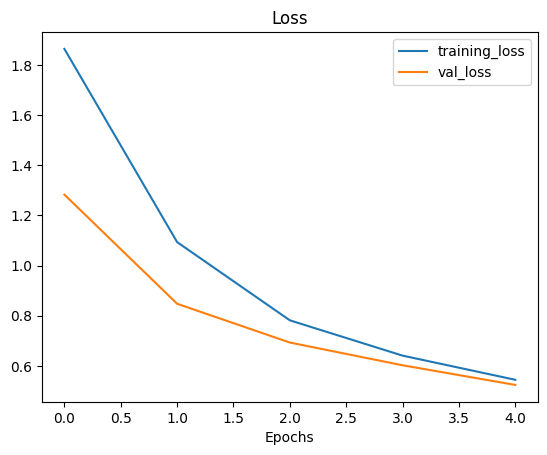

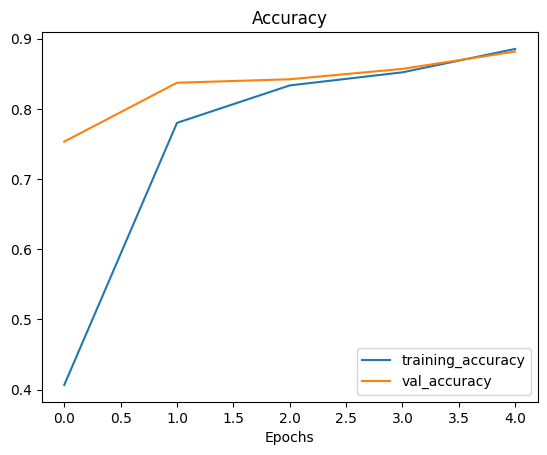

In [ ]:
plot_loss_curves(history_10_percent)



D'après l'apparence des courbes de la lost fonction du modèle EfficientNetB0, il semble que si nous continuons à former notre modèle plus longtemps ou avec plus de donner, il pourrait encore s'améliorer. et on voit bien que l'accuracy du train set continue a s'ameliorer ce qui signifie que notre modéle pourer apprendre d'avantage

# Model 2 :Building Feature extraction model with data augmentation


Deffinition de l'augmentation de données :

C'est une technique de prétraitement courante utilisée dans l'apprentissage en profondeur pour améliorer les performances et la généralisation du modèle. Elle consiste à créer de nouvelles données en appliquant des transformations aléatoires sur les données d'entraînement existantes, telles que la rotation, le zoom, le décalage horizontal ou vertical, le retournement horizontal ou vertical, l'ajout de bruit, etc.


L'augmentation de données permet d'augmenter la quantité de données d'entraînement disponibles, ce qui peut réduire le surapprentissage (overfitting) et améliorer la capacité du modèle à généraliser aux nouvelles données. Cela permet également au modèle de mieux résister aux variations mineures dans les images et de devenir plus robuste aux données bruyantes ou mal étiquetées.


Pour utiliser l'augmentation de données directement dans notre modèle, nous allons créer un modèle séquentiel Keras composé uniquement de couches de prétraitement de données, nous pouvons ensuite utiliser ce modèle séquentiel dans un autre modèle fonctionnel. Ensuite on intégre ce "modèle" en tant que couche dans notre modèle d'apprentissage par transfert

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),

], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])


In [ ]:
initial_epochs = 5
history_10_percent_data_aug = model_1.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)) # do less steps per validation (quicker)
                                         )

Epoch 1/5
24/24 [==============================] - 154s 6s/step - loss: 1.9790 - accuracy: 0.3613 - val_loss: 1.3752 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 146s 6s/step - loss: 1.2879 - accuracy: 0.7160 - val_loss: 0.9717 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 146s 6s/step - loss: 0.9967 - accuracy: 0.7707 - val_loss: 0.7645 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 146s 6s/step - loss: 0.8409 - accuracy: 0.8187 - val_loss: 0.6719 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 142s 6s/step - loss: 0.7397 - accuracy: 0.8027 - val_loss: 0.6320 - val_accuracy: 0.8289


In [ ]:
model_1.evaluate(test_data)

79/79 [==============================] - 186s 2s/step - loss: 0.6230 - accuracy: 0.8448


[0.622968316078186, 0.8447999954223633]

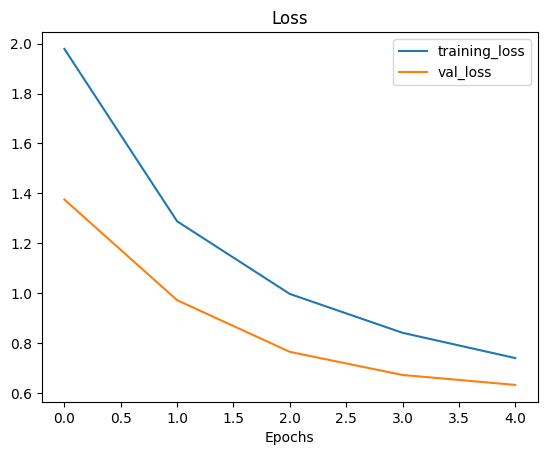

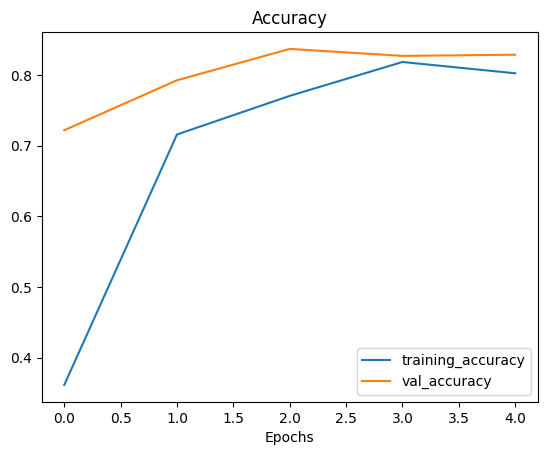

In [ ]:
plot_loss_curves(history_10_percent_data_aug)



En regardant ces derniers, les performances de notre modèle avec 10 % des données et l'augmentation des données ne sont pas aussi bonnes que le modèle avec 10 % des données sans augmentation des données (model1 85% et model2 84%), mais les courbes évoluent dans la bonne direction, ce qui signifie si nous décidions de nous entraîner plus longtemps, ses paramètres s'amélioreraient probablement.

#  model 3: Fine-tuning an existing model on 10% of the data

Jusqu'à présent, notre modèle enregistré a été entraîné à l'aide de l'apprentissage par transfert d'extraction de caractéristiques pendant 5 époques sur 10 % des données d'entraînement et de l'augmentation des données.

Cela signifie que toutes les couches du modèle de base (EfficientNetB0) ont été gelées pendant la formation.

Maintenant nous allons passer au Fine-Tuning l'idée est de commencer à personnaliser davantage le modèle pré-formé en fonction de nos propres données. Et cela en dégelant certaines de ses couches (celles les plus proches du sommet) et exécutant le modèle pendant quelques époques supplémentaires.

nous allons dégeler les 10 dernier couche du model de base et l'exécuter pendant 5 autre époques.

In [ ]:
base_model.trainable = True

# Freeze all layers except for the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False


model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
print(len(model_1.trainable_variables))


12


cela signifie que nous avons 12 couches a entrainer 10 couche pour le model de base + une couche input et une couche pour la sortie

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5
# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_1.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data))
                                 )


Epoch 5/10
24/24 [==============================] - 158s 6s/step - loss: 0.6840 - accuracy: 0.7760 - val_loss: 0.5418 - val_accuracy: 0.8174
Epoch 6/10
24/24 [==============================] - 150s 6s/step - loss: 0.3733 - accuracy: 0.8880 - val_loss: 0.5169 - val_accuracy: 0.8273
Epoch 7/10
24/24 [==============================] - 145s 6s/step - loss: 0.2345 - accuracy: 0.9187 - val_loss: 0.5016 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 109s 5s/step - loss: 0.1676 - accuracy: 0.9467 - val_loss: 0.4987 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 166s 7s/step - loss: 0.1184 - accuracy: 0.9587 - val_loss: 0.4019 - val_accuracy: 0.8635
Epoch 10/10
24/24 [==============================] - 116s 5s/step - loss: 0.0730 - accuracy: 0.9853 - val_loss: 0.5153 - val_accuracy: 0.8388


In [ ]:
results_fine_tune_10_percent = model_1.evaluate(test_data)


79/79 [==============================] - 187s 2s/step - loss: 0.4581 - accuracy: 0.8588


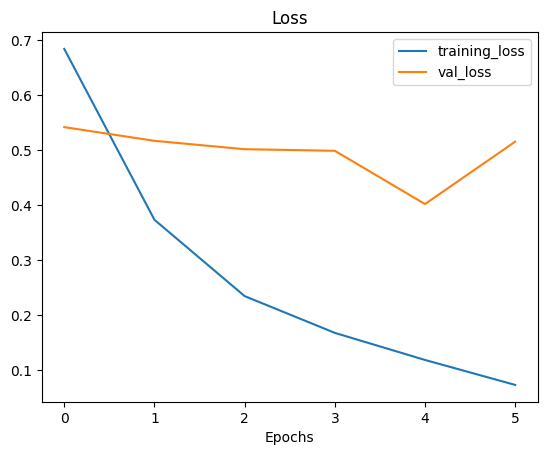

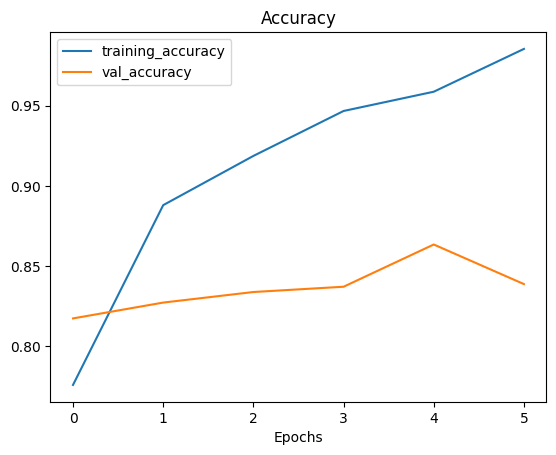

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)


nous remarquant d'apres les courbes de l'accuracy que notre model a overfiter car la courbe du train set est trés elever jusqu'à 98% et la courbe du test set s'arrete à 86%  puis descent a partir de l'epochs 4

et cela et du au manque de données car le fine-tuning fonctionne généralement mieux avec de plus grandes quantités de données.

#  model 4: Fine-tuning an existing model on all the data

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-04-07 22:31:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   188MB/s    in 2.6s    

2023-04-07 22:31:27 (188 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_1.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)))

Epoch 5/10
235/235 [==============================] - 755s 3s/step - loss: 0.5666 - accuracy: 0.8243 - val_loss: 0.2843 - val_accuracy: 0.9145
Epoch 6/10
235/235 [==============================] - 800s 3s/step - loss: 0.3948 - accuracy: 0.8735 - val_loss: 0.2700 - val_accuracy: 0.9194
Epoch 7/10
235/235 [==============================] - 735s 3s/step - loss: 0.3231 - accuracy: 0.8939 - val_loss: 0.2743 - val_accuracy: 0.9276
Epoch 8/10
235/235 [==============================] - 829s 4s/step - loss: 0.2632 - accuracy: 0.9115 - val_loss: 0.2593 - val_accuracy: 0.9260
Epoch 9/10
235/235 [==============================] - 746s 3s/step - loss: 0.2138 - accuracy: 0.9304 - val_loss: 0.2834 - val_accuracy: 0.9194
Epoch 10/10
235/235 [==============================] - 690s 3s/step - loss: 0.1977 - accuracy: 0.9341 - val_loss: 0.2244 - val_accuracy: 0.9342


In [ ]:
résultats_fine_tune_full_data = model_1.evaluate(test_data)

79/79 [==============================] - 194s 2s/step - loss: 0.2820 - accuracy: 0.9120


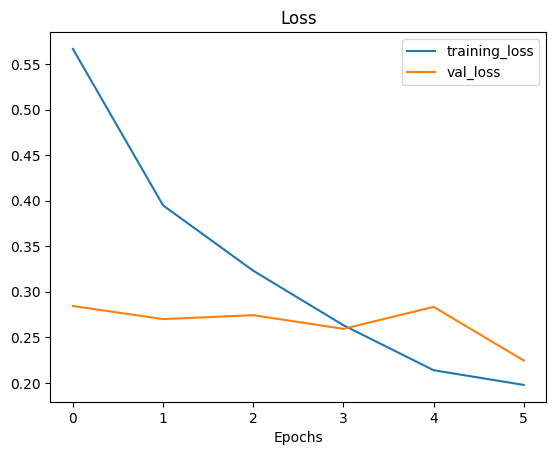

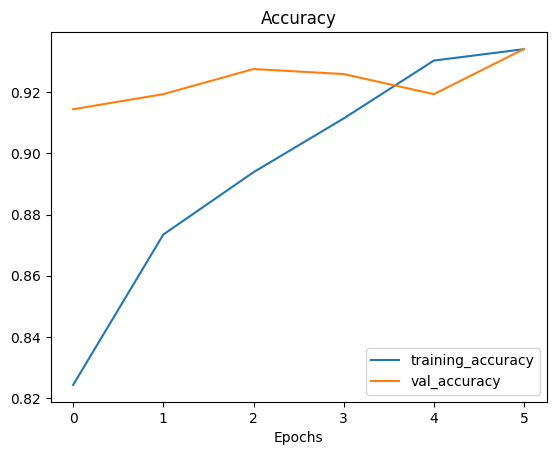

In [ ]:
plot_loss_curves(history_fine_10_classes_full)

les resultat sont époustouflant! nous avons atteint une accuracy de 93% pour test set et de 93% pour le train set et les courbe montre qu'il y a pas de overfiting, ce qui montre le pouvoir du transfer learning!

nous avons réussi a construire un modeles de classification des images de nourriture en 10 classe avec 91% d'accuracy et en quelque minute et seulement avec 7500 image de train set et 2500 image de test, et cela en transferant les performances d'un modéles pretrainer sur une large dataset (imagenet avec 1000 classe) dans notre nouveau modéle.